In [49]:
import os
import pickle
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data_folder = os.path.join("..", "data")

train_path = os.path.join(data_folder, "df_train.csv")
df_train = pd.read_csv(train_path)

val_path = os.path.join(data_folder, "df_val.csv")
df_val = pd.read_csv(val_path)

In [3]:
scaler_folder = os.path.join("..", "scalers")
scaler_path = os.path.join(scaler_folder, "std_scaler_20210921.pickle")

with open(scaler_path, "rb") as f:
    std_scaler = pickle.load(f)   

In [4]:
X_train, y_train = df_train.drop("is_canceled", axis=1), df_train["is_canceled"]
X_val, y_val = df_val.drop("is_canceled", axis=1), df_val["is_canceled"]

In [5]:
X_train_scaled = std_scaler.transform(X_train)
X_val_scaled = std_scaler.transform(X_val)

In [6]:
X_train_scaled.shape

(76406, 70)

In [7]:
def build_model():
    model = Sequential()
    model.add(Dense(units=64, input_shape=(X_train.shape[1],), activation="relu", kernel_initializer="he_uniform"))
    model.add(Dropout(0.2))
    model.add(Dense(units=64, activation="relu", kernel_initializer="he_uniform"))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
    return model

In [8]:
model = build_model()

2021-09-21 16:33:33.865320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-21 16:33:33.865339: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-21 16:33:33.865352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (henrique-kubuntu): /proc/driver/nvidia/version does not exist
2021-09-21 16:33:33.865499: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
es = EarlyStopping(patience=10, monitor="val_loss", verbose=1)
lr = ReduceLROnPlateau(patience=5, verbose=1)

In [10]:
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, 
                    validation_data=(X_val_scaled, y_val), callbacks=[es, lr])

2021-09-21 16:33:33.937540: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
1194/1194 [==============================] - 2s 1ms/step - loss: 0.4598 - binary_accuracy: 0.7807 - val_loss: 0.3954 - val_binary_accuracy: 0.8149
Epoch 2/100
1194/1194 [==============================] - 1s 992us/step - loss: 0.4052 - binary_accuracy: 0.8094 - val_loss: 0.3838 - val_binary_accuracy: 0.8206
Epoch 3/100
1194/1194 [==============================] - 1s 1ms/step - loss: 0.3928 - binary_accuracy: 0.8164 - val_loss: 0.3783 - val_binary_accuracy: 0.8211
Epoch 4/100
1194/1194 [==============================] - 1s 988us/step - loss: 0.3879 - binary_accuracy: 0.8193 - val_loss: 0.3736 - val_binary_accuracy: 0.8277
Epoch 5/100
1194/1194 [==============================] - 1s 1ms/step - loss: 0.3805 - binary_accuracy: 0.8232 - val_loss: 0.3715 - val_binary_accuracy: 0.8283
Epoch 6/100
1194/1194 [==============================] - 1s 1ms/step - loss: 0.3768 - binary_accuracy: 0.8246 - val_loss: 0.3686 - val_binary_accuracy: 0.8308
Epoch 7/100
1194/1194 [===================

In [12]:

model_folder = os.path.join("..", "models")
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

model_name = f"cancel_classifier_{datetime.now().strftime('%Y%m%d')}"

model_path = os.path.join(model_folder, model_name)
model.save(model_path)

2021-09-21 16:36:25.424093: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/cancel_classifier_20210921/assets


In [19]:
if type(history) != dict:
    history = history.history

history_folder = os.path.join("..", "histories")
if not os.path.exists(history_folder):
    os.makedirs(history_folder)

history_name = f"cancel_classifier_history_{datetime.now().strftime('%Y%m%d')}.pickle"
history_path = os.path.join(history_folder, history_name)

with open(history_path, "wb") as f:
    pickle.dump(history, f)

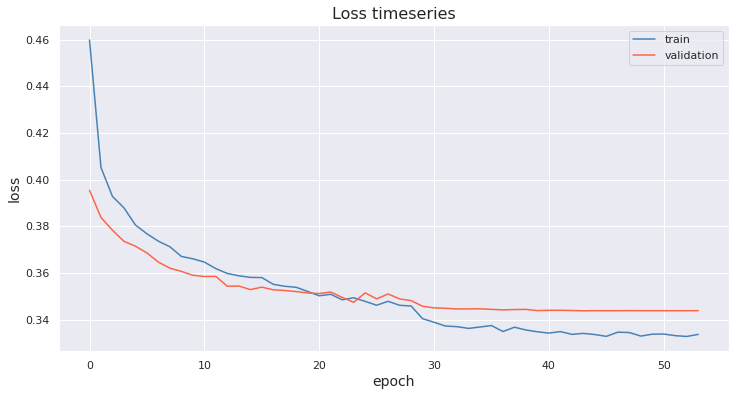

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Loss timeseries", fontsize=16)
ax.plot(history["loss"], color="steelblue", label="train")
ax.plot(history["val_loss"], color="tomato", label="validation")
ax.set_xlabel("epoch", fontsize=14)
ax.set_ylabel("loss", fontsize=14)
ax.legend()
plt.show()


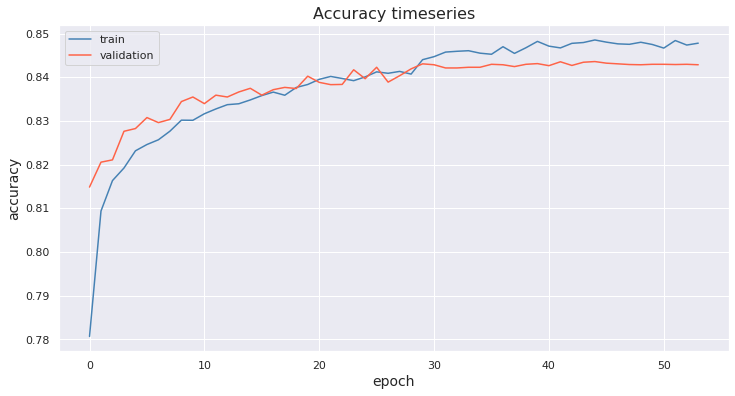

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Accuracy timeseries", fontsize=16)
ax.plot(history["binary_accuracy"], color="steelblue", label="train")
ax.plot(history["val_binary_accuracy"], color="tomato", label="validation")
ax.set_xlabel("epoch", fontsize=14)
ax.set_ylabel("accuracy", fontsize=14)
ax.legend()
plt.show()


In [39]:
y_pred_train = np.round(model.predict(X_train_scaled), 0).astype(int).ravel()
y_pred_val = np.round(model.predict(X_val_scaled), 0).astype(int).ravel()

In [61]:
train_report = classification_report(y_train.values, y_pred_train, output_dict=True)
display(train_report)
print("\ntrain recall:", train_report["1"]["recall"])

{'0': {'precision': 0.8477703069690783,
  'recall': 0.9409624779128989,
  'f1-score': 0.8919387574139391,
  'support': 48105},
 '1': {'precision': 0.8765914917655239,
  'recall': 0.7128016677855906,
  'f1-score': 0.7862571617882059,
  'support': 28301},
 'accuracy': 0.8564510640525613,
 'macro avg': {'precision': 0.862180899367301,
  'recall': 0.8268820728492448,
  'f1-score': 0.8390979596010726,
  'support': 76406},
 'weighted avg': {'precision': 0.8584457558987986,
  'recall': 0.8564510640525613,
  'f1-score': 0.8527939934189142,
  'support': 76406}}


train recall: 0.7128016677855906


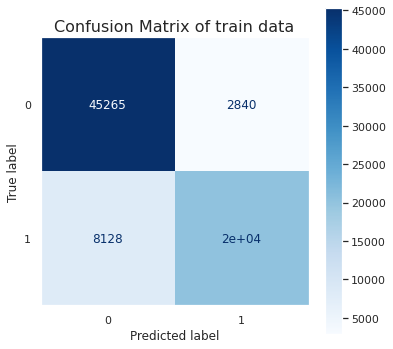

In [58]:
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Confusion Matrix of train data", fontsize=16)
disp_train.plot(cmap=plt.cm.Blues, ax=ax)
plt.grid(False)
plt.show()

In [63]:
val_report = classification_report(y_val.values, y_pred_val, output_dict=True)
display(val_report)
print("\nval recall:", val_report["1"]["recall"])

{'0': {'precision': 0.8377488399940128,
  'recall': 0.9307391702003824,
  'f1-score': 0.8817992043798495,
  'support': 12027},
 '1': {'precision': 0.8548780487804878,
  'recall': 0.6935689045936396,
  'f1-score': 0.765821303160359,
  'support': 7075},
 'accuracy': 0.8428960318291279,
 'macro avg': {'precision': 0.8463134443872503,
  'recall': 0.8121540373970111,
  'f1-score': 0.8238102537701042,
  'support': 19102},
 'weighted avg': {'precision': 0.8440931574562843,
  'recall': 0.8428960318291279,
  'f1-score': 0.8388433017975075,
  'support': 19102}}


val recall: 0.6935689045936396


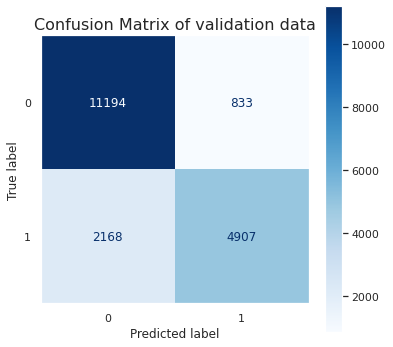

In [64]:
cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Confusion Matrix of validation data", fontsize=16)
disp_val.plot(cmap=plt.cm.Blues, ax=ax)
plt.grid(False)
plt.show()